In [1]:
##if using Anaconda (on Anaconda terminal)
#conda install -c conda-forge xgboost 
#pip install xgboost

import sys
!{sys.executable} -m pip install xgboost

  Using cached xgboost-1.7.6-py3-none-win_amd64.whl (70.9 MB)


You should consider upgrading via the 'c:\Users\greg\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
from sklearn.exceptions import ConvergenceWarning
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import split_X_y
from model_optimization import optimize_one_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [2]:
DATA_DIR = os.path.join(os.getcwd(), 'data')

## Import Labeled Data

In [3]:
#data = pd.read_csv(os.path.join(DATA_DIR, 'ind4_clustering_results.csv.gz'), compression='gzip')
data = pd.read_csv(os.path.join(DATA_DIR, 'ind4_var_genes_with_clusters.csv.gz'), compression='gzip')
data

,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4,cluster_label
0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,2
1,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.159752,1.159752,0.0,0.000000,0.0,2
2,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,1
3,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.231624,0.000000,...,0.0,0.0,0.0,0.0,1.231624,0.000000,0.0,0.962358,0.0,3
4,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.198887,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,0.00000,0.000000,0.000000,0.0,0.000000,1.382332,3.756037,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.382332,0.0,0
4010,0.00000,0.000000,3.002545,0.0,0.000000,0.000000,0.000000,0.0,1.139851,1.139851,...,0.0,0.0,0.0,0.0,1.139851,0.000000,0.0,0.000000,0.0,3
4011,0.00000,0.000000,0.000000,0.0,1.729568,1.199697,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0
4012,2.44477,2.946953,0.000000,0.0,2.142408,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.388285,0.000000,0.0,0.000000,0.0,6


0    990
1    941
2    608
3    479
4    355
5    342
6    217
7     66
8     16
Name: cluster_label, dtype: int64


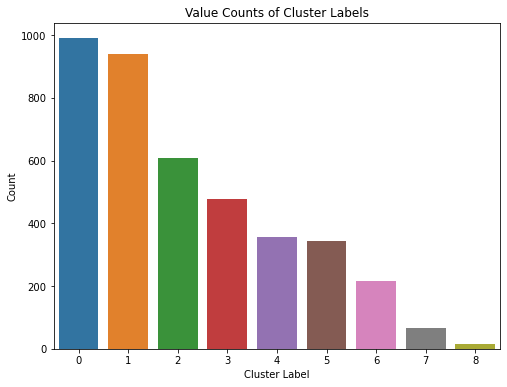

In [4]:
cluster_counts = data['cluster_label'].value_counts()
print(cluster_counts)

plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.title('Value Counts of Cluster Labels')
plt.show()

In [5]:
data.describe()

,RP11.34P13.3,FAM138A,OR4F5,RP11.34P13.7,RP11.34P13.8,RP11.34P13.14,RP11.34P13.9,FO538757.3,FO538757.2,AP006222.2,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231B
count,4014.0,4014.0,4014.0,4014.000000,4014.0,4014.0,4014.0,4014.0,4014.000000,4014.000000,...,4014.000000,4014.0,4014.000000,4014.0,4014.000000,4014.0,4014.0,4014.000000,4014.0,4014.0
mean,0.0,0.0,0.0,0.001144,0.0,0.0,0.0,0.0,0.058993,0.124318,...,0.000572,0.0,0.007943,0.0,0.000825,0.0,0.0,0.005737,0.0,0.0
std,0.0,0.0,0.0,0.030489,0.0,0.0,0.0,0.0,0.231657,0.332214,...,0.020913,0.0,0.089159,0.0,0.030620,0.0,0.0,0.082589,0.0,0.0
min,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
25%,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
50%,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
75%,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
max,0.0,0.0,0.0,1.121108,0.0,0.0,0.0,0.0,1.765982,1.760245,...,0.801262,0.0,1.446900,0.0,1.306308,0.0,0.0,1.648982,0.0,0.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4014 entries, 0 to 4013
Columns: 33695 entries, RP11.34P13.3 to cluster_label
dtypes: float64(20518), int64(13176), object(1)
memory usage: 1.0+ GB


## PreProcessing

Split X, y and turn labels from string to int with values in range (0, n_classes-1). Also isolate a 30% part of the data as a hold out test set, that will be used to test the generalization ability of the final model.

In [12]:
data = data[~data['cluster_label'].str.contains('Unclassified')]
data = data.reset_index(drop=True)

In [13]:
#X, y = split_X_y(data)
#X

X = data.drop('cluster_label', axis=1)
y = data['cluster_label']
X

,RP11.34P13.3,FAM138A,OR4F5,RP11.34P13.7,RP11.34P13.8,RP11.34P13.14,RP11.34P13.9,FO538757.3,FO538757.2,AP006222.2,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231B
0,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
1,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
2,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
3,0,0,0,0.0,0,0,0,0,0.0,0.592736,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
4,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,0,0,0,0.0,0,0,0,0,0.0,1.382332,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
3928,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
3929,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
3930,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0


In [14]:
y

0        B
1        B
2       L1
3        B
4       L1
        ..
3927    L1
3928     B
3929    L1
3930    L2
3931     B
Name: cluster_label, Length: 3932, dtype: object

In [8]:
X = X + 0.01

In [9]:
# create held-out test set for final model testing
X, X_test, y, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y, shuffle=True)

In [10]:
# reset indices
X = X.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y = y.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [11]:
y = y.to_numpy()  
y_test = y_test.to_numpy()  

In [12]:
print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(2809, 33694)
(1205, 33694)
(2809,)
(1205,)


In [13]:
X_test

,RP11.34P13.3,FAM138A,OR4F5,RP11.34P13.7,RP11.34P13.8,RP11.34P13.14,RP11.34P13.9,FO538757.3,FO538757.2,AP006222.2,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231B
0,1,1,1,1.0,1,1,1,1,1.000000,2.123204,...,1.0,1,1.000000,1,1.0,1,1,1.0,1,1
1,1,1,1,1.0,1,1,1,1,1.000000,1.000000,...,1.0,1,2.300837,1,1.0,1,1,1.0,1,1
2,1,1,1,1.0,1,1,1,1,1.000000,1.000000,...,1.0,1,1.000000,1,1.0,1,1,1.0,1,1
3,1,1,1,1.0,1,1,1,1,1.000000,1.000000,...,1.0,1,1.000000,1,1.0,1,1,1.0,1,1
4,1,1,1,1.0,1,1,1,1,1.000000,1.777832,...,1.0,1,1.000000,1,1.0,1,1,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,1,1,1,1.0,1,1,1,1,1.000000,1.000000,...,1.0,1,1.000000,1,1.0,1,1,1.0,1,1
1201,1,1,1,1.0,1,1,1,1,1.000000,1.000000,...,1.0,1,1.000000,1,1.0,1,1,1.0,1,1
1202,1,1,1,1.0,1,1,1,1,2.424929,1.000000,...,1.0,1,1.000000,1,1.0,1,1,1.0,1,1
1203,1,1,1,1.0,1,1,1,1,1.000000,1.000000,...,1.0,1,1.000000,1,1.0,1,1,1.0,1,1


In [14]:
y_test


array(['L2', 'L1', 'B', ..., 'B', 'B', 'L1'], dtype=object)

## NestedCV to optimize each model and compare them

In [15]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, fbeta_score, f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

NUM_TRIALS = 5

scoring = {'F1_weighted': make_scorer(f1_score, average='weighted'),
           'F1_micro': make_scorer(f1_score, average='micro'),
           'F1_macro': make_scorer(f1_score, average='macro'),
           'F2_weighted': make_scorer(fbeta_score, beta=2, zero_division=0, average='weighted'),
           'F2_micro': make_scorer(fbeta_score, beta=2, zero_division=0, average='micro'),
           'F2_macro': make_scorer(fbeta_score, beta=2, zero_division=0, average='macro'),
           'MCC': make_scorer(matthews_corrcoef),
           'Balanced_Accuracy': 'balanced_accuracy',
           }

def get_outer_scores(y_true, y_pred, results_df, idx):
    """
    Fill the dataframe which will contain all the scores for each experiment of a specific classifier

    :param y_true: True labels
    :param y_pred: Predicted labels by the best estimator of each inner cv
    :param results_df: The dataframe to fill
    :param idx: The index the results should be put
    :return: The dataframe filled at the indicated index
    """
    results_df['MCC'].loc[idx] = matthews_corrcoef(y_true, y_pred)
    results_df['F1_weighted'].loc[idx] = f1_score(y_true, y_pred, average='weighted')
    results_df['F1_micro'].loc[idx] = f1_score(y_true, y_pred, average='micro')
    results_df['F1_macro'].loc[idx] = f1_score(y_true, y_pred, average='macro')
    results_df['F2_weighted'].loc[idx] = fbeta_score(y_true, y_pred, beta=2, zero_division=0, average='weighted')
    results_df['F2_micro'].loc[idx] = fbeta_score(y_true, y_pred, beta=2, zero_division=0, average='micro')
    results_df['F2_macro'].loc[idx] = f1_score(y_true, y_pred, average='macro')
    results_df['Balanced_Accuracy'].loc[idx] = balanced_accuracy_score(y_true, y_pred)

    return results_df.copy()

def run_ncv(data_x, labels, clf_name):
    """
    Run an NCV experiment for a specific classifier whose name is required as input

    :param data_x: Dataframe of samples and features
    :param labels: numpy array of labels
    :param clf_name: a string indicating the name of the classifier
    :return: tuple
        Result scores of all experiments in a dataframe (experiment_number x score) and a list with the best parameters
        for each experiment just for inspection (DO NOT USE)
    """
    # scaler = StandardScaler()
    # scaled_data_x = scaler.fit_transform(data_x, labels)

    trial_results_df = pd.DataFrame(columns=scoring.keys(), index=[i for i in range(NUM_TRIALS)])
    best_params_list = []
    for num_trial in range(NUM_TRIALS):
        outer_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=num_trial)
        count = 0
        for train_ix, test_ix in outer_cv.split(data_x, labels):
            # print(train_ix)
            x_train, x_test = data_x.loc[train_ix], data_x.loc[test_ix]
            y_train, y_test = labels[train_ix], labels[test_ix]

            #scaler = StandardScaler().fit(x_train)
            #x_train = scaler.transform(x_train)
            #x_test = scaler.transform(x_test)
            pca = PCA(n_components=10).fit(x_train)
            x_train = pca.transform(x_train)
            x_test = pca.transform(x_test)

            # count += 1
            seed = num_trial

            best_estimator, best_params = optimize_one_model(x_train, y_train, clf_name, seed)

            best_params_list.append(best_params)
            y_pred = best_estimator.predict(x_test)
            trial_results_df = get_outer_scores(y_test, y_pred, trial_results_df.copy(), num_trial+count)
            
            count += 1
    # print(best_params_list)

    return trial_results_df, best_params_list

def run_all_classifiers(data, targets):
    """
    START HERE
    Begin the nested cv experiment here. This function iterates over all classifier names and starts a ncv experiment for
    each one.

    :param data: A dataframe containing the features for all available samples (aka PCs)
    :param targets: The labels after turning them into numbers of range 0 to num_classes-1
    :return: Tuple
        A dictionary with keys the names of the classifiers and values the dataframes containing the scores for each,
        A dictionary containing the best params for each experiment and each classifier (Only used for inspection)
    """
    results_dict = {}
    params_dict = {}
    classifiers = {0: 'svm',
                   1: 'lr',
                   2: 'gnb',
                   3: 'rf',
                   4: 'xgb'
                   }

    for clf in classifiers.values():
        print(f'Starting NCV experiment for classifier {clf}')
        # res_df = nested_cv(clf, hyperparam_grids[key], x, y)
        res_df, best_params = run_ncv(data, targets, clf)
        results_dict[clf] = res_df
        params_dict[clf] = best_params
        # break
    return results_dict, params_dict

## Plotting functions

In [16]:
def plot_clfs_metrics(results_dict):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(6, 9))
    my_palette = sns.color_palette("Set3")

    row, col = 0, 0
    for metric in scoring.keys():
        metric_data = pd.DataFrame()
        for clf_key, df in results_dict.items():
            metric_data[clf_key.upper()] = df[metric]
        sns.boxplot(data=metric_data, ax=axes[row][col], width=0.5, palette=my_palette)
        axes[row][col].set_title(metric)

        col += 1
        if col == 2:
            col = 0
            row += 1

    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    fig.suptitle('Classifiers metrics comparison after nested CV experiments', fontsize=22)
    plt.savefig('metrics_comparison.pdf')
    plt.show()


def plot_mccs(mcc_dict):
    fig, ax = plt.subplots(figsize=(8, 7))
    x_labels = [key.upper() for key in mcc_dict.keys()]
    y_values = mcc_dict.values()
    my_cmap = plt.get_cmap("Set3")
    plt.bar(x_labels, y_values, color=my_cmap.colors)
    plt.title('MCC mean values comparison between different classifiers', fontsize=22)
    ax.xaxis.label.set_size(8)
    ax.yaxis.label.set_size(8)
    ax.bar_label(ax.containers[0])
    plt.xlabel('Classifiers', fontsize=10)
    plt.savefig('mcc_compare.pdf')
    plt.show()


def plot_mean_std_errors(std_dict):
    fig, ax = plt.subplots(figsize=(8, 7))
    x_labels = [key.upper() for key in std_dict.keys()]
    y_values = std_dict.values()
    my_cmap = plt.get_cmap("Set3")
    plt.bar(x_labels, y_values, color=my_cmap.colors)
    plt.title('MCC standard error comparison between different classifiers', fontsize=22)
    ax.xaxis.label.set_size(8)
    ax.yaxis.label.set_size(8)
    ax.bar_label(ax.containers[0])
    plt.xlabel('Classifiers', fontsize=10)
    plt.savefig('std_e_compare.pdf')
    plt.show()


def compare_mean_mccs(results_dict):
    """
    For each classifier calculate mean MCC score and standard error
    :param results_dict: A dictionary with keys the names of the classifiers and values dataframes with the scores of
    the ncv experiments done for each one
    :return:
    Dictionary for each classifier's mean MCC score
    """
    mccs = {}
    std_errors = {}
    for key, df in results_dict.items():
        mean_mcc = df['MCC'].mean()
        std_error_mcc = df['MCC'].std(ddof=1) / np.sqrt(df['MCC'].shape[0])
        mccs[key] = mean_mcc
        std_errors[key] = std_error_mcc
    plot_mccs(mccs)
    plot_mean_std_errors(std_errors)
    return mccs

In [17]:
X.shape

(2809, 33694)

In [18]:
X.loc[[0,1,2,3]]


,RP11.34P13.3,FAM138A,OR4F5,RP11.34P13.7,RP11.34P13.8,RP11.34P13.14,RP11.34P13.9,FO538757.3,FO538757.2,AP006222.2,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231B
0,1,1,1,1.0,1,1,1,1,1.000000,1.0,...,1.0,1,1.0,1,1.0,1,1,1.0,1,1
1,1,1,1,1.0,1,1,1,1,1.000000,1.0,...,1.0,1,1.0,1,1.0,1,1,1.0,1,1
2,1,1,1,1.0,1,1,1,1,1.000000,1.0,...,1.0,1,1.0,1,1.0,1,1,1.0,1,1
3,1,1,1,1.0,1,1,1,1,1.495697,1.0,...,1.0,1,1.0,1,1.0,1,1,1.0,1,1


In [19]:
results, params_dict = run_all_classifiers(X,y)

Starting NCV experiment for classifier svm


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Starting NCV experiment for classifier lr


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-25 17:25:31,552] Trial 0 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.0001091290135059375} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:25:31,560] Trial 0 failed with value nan.
[W 2023-06-25 17:25:31,822] Trial 8 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.1932675063964395} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:25:31,822] Trial 8 failed with value nan.
[W 2023-06-25 17:25:31,934] Trial 4 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.015047671994054582} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:25:31,942] Trial 4 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-25 17:25:39,855] Trial 1 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.00011623306590120662} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:25:39,864] Trial 1 failed with value nan.
[W 2023-06-25 17:25:39,879] Trial 2 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.2863171802692478} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:25:39,887] Trial 2 failed with value nan.
[W 2023-06-25 17:25:39,887] Trial 3 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.07697999525335991} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:25:39,896] Trial 3 failed with value nan.
[W 2023-06-25 17:25:39,976] Trial 8 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.001574350369223605} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:25:39,984] Trial 8 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-25 17:25:47,928] Trial 5 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.03494875979925885} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:25:47,944] Trial 5 failed with value nan.
[W 2023-06-25 17:25:47,976] Trial 3 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.0006359470799134971} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:25:47,984] Trial 3 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-25 17:25:58,798] Trial 0 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.010474099730749396} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:25:58,814] Trial 0 failed with value nan.
[W 2023-06-25 17:25:58,830] Trial 1 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.012191167409111834} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:25:58,838] Trial 1 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-25 17:26:07,199] Trial 4 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.0012299216629366057} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:07,207] Trial 4 failed with value nan.
[W 2023-06-25 17:26:07,388] Trial 7 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.0002844579047956864} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:07,392] Trial 7 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-25 17:26:15,829] Trial 9 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.006042489530572419} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:15,833] Trial 9 failed with value nan.
[W 2023-06-25 17:26:15,837] Trial 7 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.0192041023322886} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:15,845] Trial 7 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-25 17:26:23,309] Trial 2 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.002911816522857345} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:23,313] Trial 1 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.008252487333866652} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:23,317] Trial 2 failed with value nan.
[W 2023-06-25 17:26:23,321] Trial 1 failed with value nan.
[W 2023-06-25 17:26:23,361] Trial 9 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.275668508821949} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:23,369] Trial 9 failed with value nan.
[W 2023-06-25 17:26:23,958] Trial 6 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.0001050689441306756} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:23,962] Trial 6 failed with value nan.
[W 2023-06

  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-25 17:26:31,441] Trial 0 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.0002615759963820058} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:31,453] Trial 0 failed with value nan.
[W 2023-06-25 17:26:31,677] Trial 2 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.0005259864765251592} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:31,689] Trial 2 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-25 17:26:40,096] Trial 0 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.0694322038950728} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:40,108] Trial 0 failed with value nan.
[W 2023-06-25 17:26:40,281] Trial 7 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.28973083101598957} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:40,285] Trial 7 failed with value nan.
[W 2023-06-25 17:26:40,333] Trial 9 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.003933103437511046} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:40,345] Trial 9 failed with value nan.
[W 2023-06-25 17:26:40,345] Trial 5 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.008571083528763236} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:40,355] Trial 5 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-25 17:26:47,666] Trial 1 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.008868347797041466} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:26:47,674] Trial 1 failed with value nan.
Starting NCV experiment for classifier gnb


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Starting NCV experiment for classifier rf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Starting NCV experiment for classifier xgb


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-25 17:29:48,590] Trial 3 failed with parameters: {'xgb_eta': 0.024304970013663052, 'xgb_gamma': 43, 'xgb_min_child_weight': 0.5569383323300631} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:29:48,593] Trial 3 failed with value nan.
[W 2023-06-25 17:29:48,599] Trial 2 failed with parameters: {'xgb_eta': 0.12914149768999977, 'xgb_gamma': 43, 'xgb_min_child_weight': 2.527841972612765} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:29:48,604] Trial 2 failed with value nan.
[W 2023-06-25 17:29:48,604] Trial 0 failed with parameters: {'xgb_eta': 0.2931130983033589, 'xgb_gamma': 26, 'xgb_min_child_weight': 0.019708103229380547} because of the following error: The value nan is not acceptable..
[W 2023-06-25 17:29:48,615] Trial 0 failed with value nan.
[W 2023-06-25 17:29:48,617] Trial 4 failed with parameters: {'xgb_eta': 0.024531234014496917, 'xgb_gamma': 24, 'xgb_min_child_weight': 2.0931878502521424} because

ValueError: No trials are completed yet.

In [34]:
for key, value in params_dict.items():
    print(f'Params for classifier {key}')
    for idx, param in enumerate(value):
        print(f'Params of trial {idx}: {param}')

Params for classifier svm
Params of trial 0: {'c_svm': 6.3945621198812015, 'gamma_svm': 0.02458830637402057}
Params of trial 1: {'c_svm': 6.819453915919198, 'gamma_svm': 0.027575662666254788}
Params of trial 2: {'c_svm': 7.281303305449594, 'gamma_svm': 0.042422278378617125}
Params of trial 3: {'c_svm': 1.3613106383434626, 'gamma_svm': 0.02954767140424381}
Params of trial 4: {'c_svm': 6.009909065458208, 'gamma_svm': 0.03370104494248146}
Params of trial 5: {'c_svm': 7.672448874588315, 'gamma_svm': 0.047861318126352304}
Params of trial 6: {'c_svm': 2.505446568193863, 'gamma_svm': 0.01690196595991776}
Params of trial 7: {'c_svm': 8.850733509370041, 'gamma_svm': 0.02479132789673762}
Params of trial 8: {'c_svm': 1.029915950386597, 'gamma_svm': 0.055367025908463416}
Params of trial 9: {'c_svm': 9.460594977533622, 'gamma_svm': 0.014001468323217279}
Params for classifier lr
Params of trial 0: {'lr_solver': 'lbfgs', 'lr_c': 9.609876380408055}
Params of trial 1: {'lr_solver': 'saga', 'lr_c': 8.43

## Check MCC scores to compare algorithms

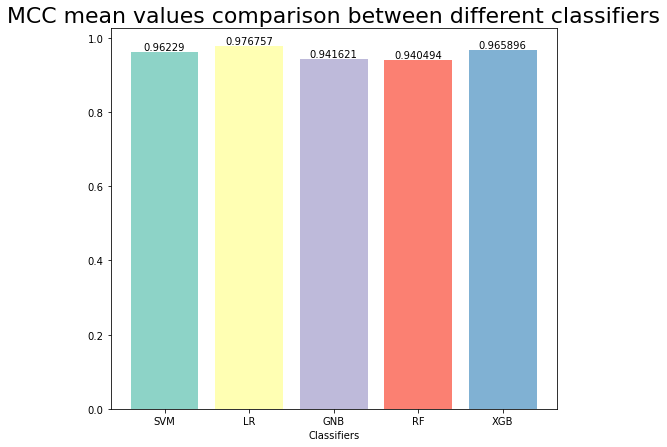

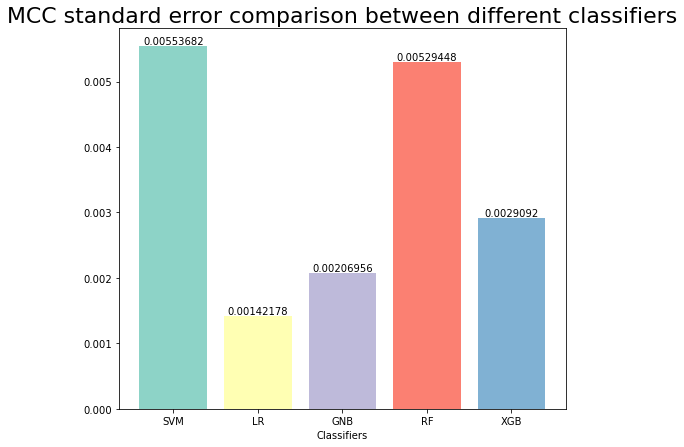

{'svm': 0.962290254172839,
 'lr': 0.9767573321829733,
 'gnb': 0.9416206076151589,
 'rf': 0.9404943837386437,
 'xgb': 0.965895971657376}

In [35]:
mccs_dict = compare_mean_mccs(results)
mccs_dict

## Check boxplots of all other collected metrics for all classifiers

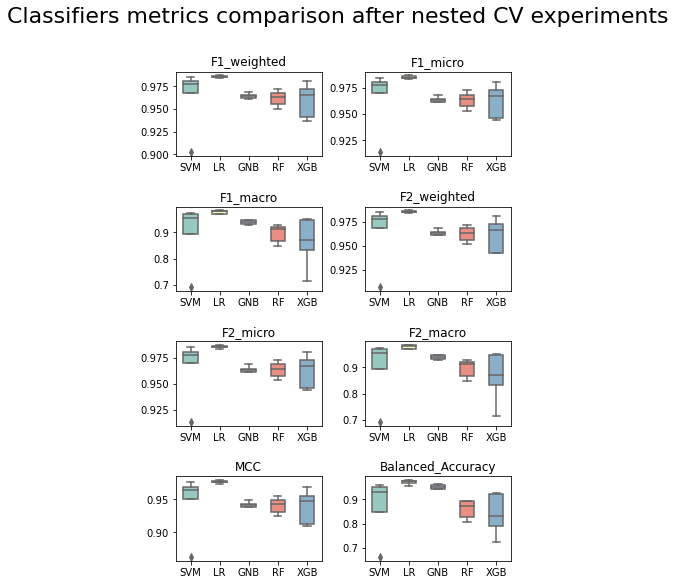

In [26]:
plot_clfs_metrics(results)